# ML Training Data Generation with Parameter Sweeps

This notebook demonstrates how to generate synthetic training datasets for machine learning by systematically varying model parameters.

**Use cases:**
- Training neural networks for spectroscopy analysis
- Testing parameter recovery algorithms
- Exploring parameter sensitivity and identifiability
- Generating data for uncertainty quantification studies

In [1]:
import os
import numpy as np
import trspecfit
from trspecfit.utils.sweep import ParameterSweep, SweepDataset

## 1. Set Up Model

First, create your model as usual. This will be the "ground truth" model that we'll vary to generate training data.

In [2]:
# Create parent project
project = trspecfit.Project(path=os.getcwd())

# Create file instance with axes
file = trspecfit.File(
    parent_project=project,
    energy=np.arange(0, 20, 0.01),
    time=np.arange(-10, 100, 0.1)
)

In [3]:
# Load energy-resolved model
file.load_model(
    model_yaml='models_energy.yaml',
    model_info=['base']
)

Loading model to describe energy- (and time-)dependent data: base


In [4]:
# Add time dependence to peak 1 position
file.add_time_dependence(
    model_yaml="models_time.yaml",  # from subcycles/
    model_info=['MonoExpNeg'],  # IRF + negative shift
    par_name="GLP_01_x0"
)

# Add time dependence to peak 2 position  
file.add_time_dependence(
    model_yaml="models_time.yaml",
    model_info=['MonoExpPos'],  # IRF + positive shift (linked)
    par_name="GLP_02_x0"
)

Loading model to describe time-dependence of a model parameter: GLP_01_x0 of MonoExpNeg model
Loading model to describe time-dependence of a model parameter: GLP_02_x0 of MonoExpPos model


In [5]:
# Examine the model structure
file.model_active.describe()

model name: base
function: Offset from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: Shirley from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: GLP from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: GLP from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
all (1D flattened if applicable) lmfit.Parameters(): [sorted alphabetically]
Name                        Value      Min      Max   Stderr     Vary     Expr Brute_Step
GLP_01_A                       20        5       25     None     True     None     None
GLP_01_F                        1     0.7

## 2. Define Parameter Space

Choose which parameters to vary and how. You can use:
- **Discrete ranges**: `add_range()` for specific values
- **Continuous distributions**: `add_uniform()`, `add_normal()`, `add_lognormal()`

Strategy options:
- **`'grid'`**: Full combinatorial - every combination (good for small spaces)
- **`'random'`**: Independent sampling (scalable for ML)

### Example 1: Small Grid Sweep

Good for systematic exploration of a few parameter values.

In [6]:
# # Define a small grid
# sweep_grid = ParameterSweep(strategy='grid', seed=42)
# sweep_grid.add_range('GLP_01_x0_expFun_01_A', [0.25, 1, 4])
# sweep_grid.add_uniform('GLP_01_x0_expFun_01_tau', min_val=5, max_val=25, n_samples=3)

# print(f"Total configurations: {sweep_grid.get_n_configs()}")
# print("\nFirst 5 configurations:")
# for i, config in enumerate(sweep_grid):
#     if i >= 5:
#         break
#     print(f"  Config {i}: {config}")

### Example 2: Random Sampling (Recommended for ML)

Samples parameters independently - scales to large datasets.

In [7]:
# Define random sampling sweep
sweep_random = ParameterSweep(strategy='random', seed=42)

# Vary peak amplitude (Peak 2 auto-calculated as 3/4 * Peak 1)
sweep_random.add_uniform('GLP_01_A', min_val=8, max_val=12, n_samples=100)

# Vary peak position (Peak 2 auto-calculated as Peak 1 + 3.6)
sweep_random.add_uniform('GLP_01_x0', min_val=80, max_val=90, n_samples=100)

# Vary dynamics amplitude - use Johannes's specific values (Peak 2 auto-calculated as -Peak 1)
sweep_random.add_range('GLP_01_x0_expFun_01_A', 
                       [1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0])

# Vary decay time constant (Peak 2 shares same tau)
sweep_random.add_uniform('GLP_01_x0_expFun_01_tau', min_val=10, max_val=80, n_samples=100)

print(f"Total configurations: {sweep_random.get_n_configs()}")
print("\nFirst 5 configurations:")
for i, config in enumerate(sweep_random):
    if i >= 5:
        break
    print(f"  Config {i}:")
    for k, v in config.items():
        print(f"    {k}: {v:.3f}")

Total configurations: 100

First 5 configurations:
  Config 0:
    GLP_01_A: 9.498
    GLP_01_x0: 89.507
    GLP_01_x0_expFun_01_A: 0.000
    GLP_01_x0_expFun_01_tau: 64.578
  Config 1:
    GLP_01_A: 10.387
    GLP_01_x0: 84.458
    GLP_01_x0_expFun_01_A: 0.010
    GLP_01_x0_expFun_01_tau: 14.066
  Config 2:
    GLP_01_A: 11.465
    GLP_01_x0: 86.011
    GLP_01_x0_expFun_01_A: 0.005
    GLP_01_x0_expFun_01_tau: 55.562
  Config 3:
    GLP_01_A: 8.226
    GLP_01_x0: 87.220
    GLP_01_x0_expFun_01_A: 0.020
    GLP_01_x0_expFun_01_tau: 10.055
  Config 4:
    GLP_01_A: 11.969
    GLP_01_x0: 86.175
    GLP_01_x0_expFun_01_A: 0.001
    GLP_01_x0_expFun_01_tau: 46.733


## 3. Generate Training Data

Use `simulate_parameter_sweep()` to generate datasets. This:
1. Iterates through parameter configurations
2. Updates model parameters
3. Generates N noisy realizations per configuration
4. Saves everything to HDF5 file

**Memory efficiency**: Only one configuration in memory at a time!

In [8]:
# Create simulator
sim = trspecfit.Simulator(
    model=file.model_active,
    detection='analog',
    noise_level=0.05,
    noise_type='poisson',
    seed=42
)

### Small Test Dataset (Quick)

Generate a small dataset first to verify everything works.

In [9]:
# # Use the grid sweep for quick test
# sim.simulate_parameter_sweep(
#     parameter_sweep=sweep_grid,
#     N_realizations=3,
#     filepath='test_sweep.h5',
#     show_progress=True
# )

### Large Training Dataset (Takes Time)

Generate the full ML training dataset. Adjust N_realizations based on your needs:
- **N=10-20**: Good for most ML applications
- **N=50+**: For robust uncertainty quantification

In [10]:
# Generate large training dataset
# WARNING: This will take several minutes!
sim.simulate_parameter_sweep(
    parameter_sweep=sweep_random,
    N_realizations=20,
    filepath='ml_training_data.h5',
    show_progress=True
)

# Result: 100 configs × 20 realizations = 2000 training examples

Starting parameter sweep:
  Total configurations: 100
  Realizations per config: 20
  Total datasets: 2000
  Output file: /Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/examples/subcycles/simulated_data/ml_training_data.h5

Processing config 1/100: {GLP_01_A=9.5, GLP_01_x0=89.5, GLP_01_x0_expFun_01_A=0, GLP_01_x0_expFun_01_tau=64.6}
  ✓ Saved config 1 with 20 realizations
Processing config 2/100: {GLP_01_A=8.25, GLP_01_x0=89.7, GLP_01_x0_expFun_01_A=0.1, GLP_01_x0_expFun_01_tau=39.5}
  ✓ Saved config 2 with 20 realizations
Processing config 3/100: {GLP_01_A=10.6, GLP_01_x0=81.8, GLP_01_x0_expFun_01_A=0.05, GLP_01_x0_expFun_01_tau=34.6}
  ✓ Saved config 3 with 20 realizations
Processing config 4/100: {GLP_01_A=8.23, GLP_01_x0=89.4, GLP_01_x0_expFun_01_A=0.2, GLP_01_x0_expFun_01_tau=67}
  ✓ Saved config 4 with 20 realizations
Processing config 5/100: {GLP_01_A=11, GLP_01_x0=89.3, GLP_01_x0_expFun_01_A=0.05, GLP_01_x0_expFun_01_tau=78.9}
  ✓ Saved config 5 with 20

## 4. Inspect Generated Data

Use `SweepDataset` to examine what was generated.

In [11]:
# Load dataset inspector
dataset = SweepDataset('simulated_data/ml_training_data.h5')
#dataset = SweepDataset('simulated_data/test_sweep.h5')

In [12]:
# Print comprehensive summary
dataset.print_summary()


Dataset: simulated_data/ml_training_data.h5
Configurations: 100
Realizations per config: 20
Total datasets: 2000

Data dimensions: 2D (time × energy)
Energy points: 2000
Time points: 1100

Detection: analog
Noise level: 0.05
Noise type: poisson

Parameter space:
  GLP_01_A: uniform(8, 12) - 100 samples
  GLP_01_x0: uniform(80, 90) - 100 samples
  GLP_01_x0_expFun_01_A: discrete 11 values [0 ... 1]
  GLP_01_x0_expFun_01_tau: uniform(10, 80) - 100 samples



In [13]:
# Get parameter summary as DataFrame
df = dataset.get_parameter_summary()
print("\nParameter configurations:")
display(df.round(3))

print("\nStatistical summary:")
display(df.describe().round(3))


Parameter configurations:


,GLP_01_A,GLP_01_x0,GLP_01_x0_expFun_01_A,GLP_01_x0_expFun_01_tau
config_idx,,,,
0,9.498,89.507,0.000,64.578
1,8.252,89.748,0.100,39.453
2,10.568,81.796,0.050,34.559
3,8.234,89.361,0.200,66.999
4,10.975,89.279,0.050,78.862
...,...,...,...,...
95,11.414,89.747,0.005,44.510
96,11.555,81.944,0.010,72.280
97,8.977,84.403,0.020,25.512



Statistical summary:


,GLP_01_A,GLP_01_x0,GLP_01_x0_expFun_01_A,GLP_01_x0_expFun_01_tau
count,100.000,100.000,100.000,100.000
mean,9.971,85.085,0.171,47.405
std,1.251,3.037,0.302,19.849
min,8.026,80.013,0.000,11.762
25%,8.854,82.322,0.002,30.074
50%,10.122,84.866,0.020,49.798
75%,11.074,87.904,0.200,63.680
max,11.960,89.919,1.000,78.947


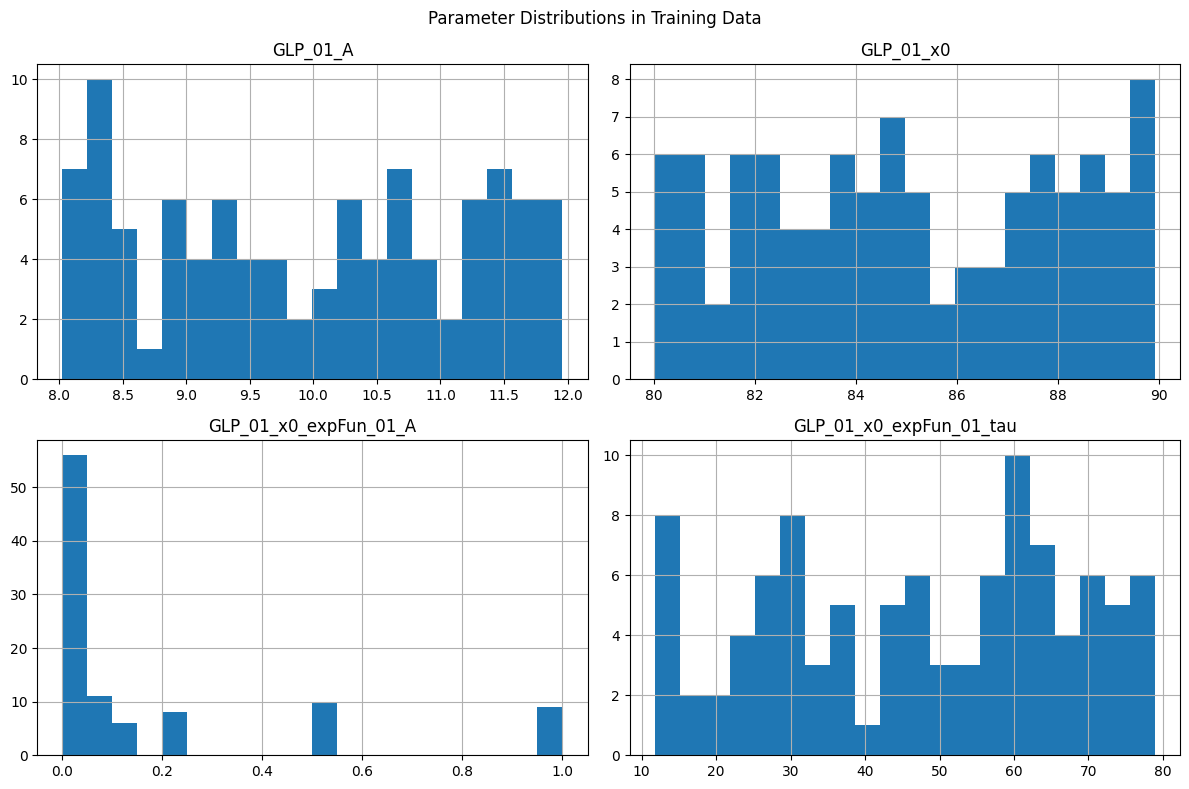

In [14]:
# Visualize parameter distributions
import matplotlib.pyplot as plt

df.hist(figsize=(12, 8), bins=20)
plt.suptitle('Parameter Distributions in Training Data')
plt.tight_layout()
plt.show()

In [15]:
# Load a specific configuration for inspection
config = dataset.load_config(0)

print(f"Config 0 parameters:")
for k, v in config['parameters'].items():
    print(f"  {k}: {v:.3f}")

print(f"\nData shapes:")
print(f"  Clean: {config['clean'].shape}")
print(f"  Noisy realizations: {len(config['noisy'])}")
print(f"  Each realization: {config['noisy'][0].shape}")

Config 0 parameters:
  GLP_01_A: 9.498
  GLP_01_x0: 89.507
  GLP_01_x0_expFun_01_A: 0.000
  GLP_01_x0_expFun_01_tau: 64.578

Data shapes:
  Clean: (1100, 2000)
  Noisy realizations: 20
  Each realization: (1100, 2000)



Visualize configuration 0:
  - Or use your own plotting with dataset.get_axes() for x/y axes
  - Or (see below): Load config, set sim.data_clean/noisy, call sim.plot_comparison(dim=2)


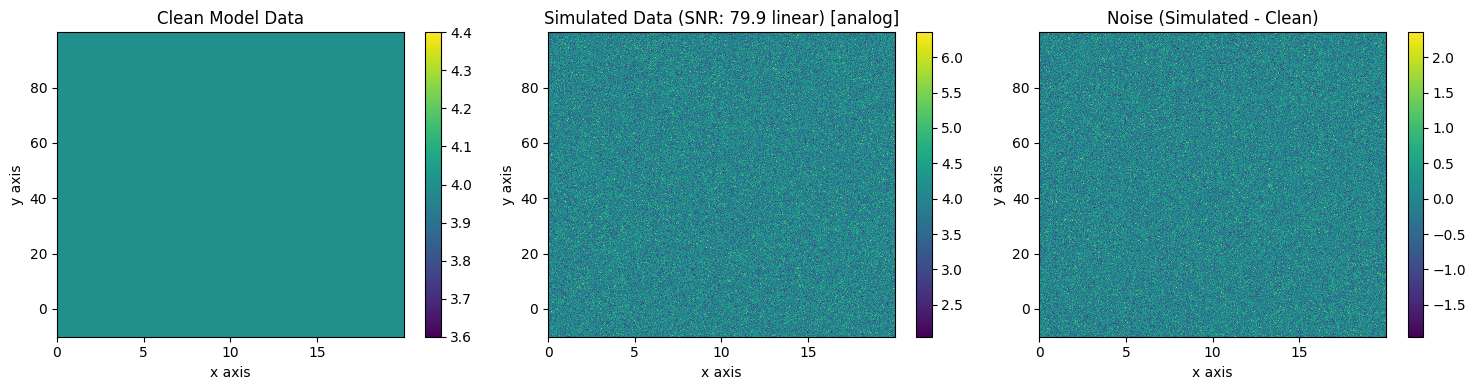

In [16]:
# Visualize a configuration (uses simulator's built-in plotting)
print("\nVisualize configuration 0:")
print(f"  - Or use your own plotting with dataset.get_axes() for x/y axes")
print(f"  - Or (see below): Load config, set sim.data_clean/noisy, call sim.plot_comparison(dim=2)")
# Temporarily set simulator data to this config for plotting
sim.data_clean = config['clean']
sim.data_noisy = config['noisy'][0]
sim.noise = config['noisy'][0] - config['clean']
sim.plot_comparison(dim=2)

## 5. Loading Data for ML Training

For actual ML training, you'll typically write a custom data loader for your framework (PyTorch, TensorFlow, etc.). Here's a basic example using h5py directly:

In [ ]:
import h5py

# Example: Load all data into memory (for small datasets)
def load_training_data(filepath, param_names):
    """
    Load parameter sweep data for ML training.
    
    Parameters
    ----------
    filepath : str
        Path to HDF5 file
    param_names : list of str
        Which parameters to extract as targets
    
    Returns
    -------
    X : list of arrays
        Input spectra (noisy realizations)
    y : list of arrays
        Target parameters for each spectrum
    """
    X = []  # Input: noisy spectra
    y = []  # Target: parameter values
    
    with h5py.File(filepath, 'r') as f:
        n_configs = f['metadata'].attrs['n_configs']
        
        for config_idx in range(n_configs):
            config_name = f'config_{config_idx:06d}'
            config_group = f['parameter_configs'][config_name]
            data_group = f['simulated_data'][config_name]
            
            # Extract target parameters
            targets = [config_group.attrs[name] for name in param_names]
            
            # Load all noisy realizations for this config
            for real_key in sorted(data_group.keys()):
                spectrum = data_group[real_key][:]
                X.append(spectrum)
                y.append(targets)
    
    return np.array(X), np.array(y)

# Example usage
X_train, y_train = load_training_data(
    'simulated_data/test_sweep.h5',
    param_names=['GLP_01_x0_expFun_01_A', 'GLP_01_x0_expFun_01_tau']
)

print(f"Training data shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nFirst example target: {y_train[0]}")

### Example: PyTorch Dataset Class

For large datasets that don't fit in memory:

In [ ]:
# Uncomment if you have PyTorch installed:
# import torch
# from torch.utils.data import Dataset, DataLoader
# 
# class SpectroscopyDataset(Dataset):
#     """PyTorch dataset for parameter sweep data."""
#     
#     def __init__(self, filepath, param_names, transform=None):
#         self.filepath = filepath
#         self.param_names = param_names
#         self.transform = transform
#         
#         # Load metadata
#         with h5py.File(filepath, 'r') as f:
#             self.n_configs = f['metadata'].attrs['n_configs']
#             self.n_realizations = f['metadata'].attrs['n_realizations_per_config']
#         
#         self.total_samples = self.n_configs * self.n_realizations
#     
#     def __len__(self):
#         return self.total_samples
#     
#     def __getitem__(self, idx):
#         # Calculate which config and realization
#         config_idx = idx // self.n_realizations
#         real_idx = idx % self.n_realizations
#         
#         with h5py.File(self.filepath, 'r') as f:
#             config_name = f'config_{config_idx:06d}'
#             config_group = f['parameter_configs'][config_name]
#             data_group = f['simulated_data'][config_name]
#             
#             # Load spectrum
#             spectrum = data_group[f'{real_idx:06d}'][:]
#             
#             # Load target parameters
#             targets = [config_group.attrs[name] for name in self.param_names]
#         
#         if self.transform:
#             spectrum = self.transform(spectrum)
#         
#         return torch.FloatTensor(spectrum), torch.FloatTensor(targets)
# 
# # Create data loader
# dataset = SpectroscopyDataset(
#     'simulated_data/test_sweep.h5',
#     param_names=['GLP_01_x0_expFun_01_A', 'GLP_01_x0_expFun_01_tau']
# )
# 
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# 
# # Use in training loop
# for batch_spectra, batch_targets in train_loader:
#     # ... training code ...
#     pass

print("See commented code above for PyTorch example")

## Tips for ML Training Data

**Parameter Selection:**
- Start with 2-3 most important parameters
- Use realistic ranges from your experimental data
- Include correlations if parameters are physically related

**Dataset Size:**
- Small networks: 1,000-5,000 examples often sufficient
- Larger networks: 10,000-50,000 examples
- More realizations per config = better uncertainty estimates

**Noise Level:**
- Match your experimental SNR
- Can generate multiple datasets with different noise levels
- Consider augmentation during training (add more noise)

**Validation Strategy:**
- Split by configuration, not by realization
- Test on held-out parameter ranges
- Validate on real experimental data when possible